In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from layers import FullyConnectedLayer, ReLULayer, ConvolutionalLayer, MaxPoolingLayer, Flattener
from model import Discriminator, GeneratorModel
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD, Adam
from metrics import multiclass_accuracy
import cupy as cp
import cv2

cp.cuda.runtime.setDevice(1)

In [3]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
x_train[0].shape

(28, 28)

In [62]:
from sklearn.model_selection import train_test_split
def prepare_for_neural_network(train_X, test_X):
    train_X = train_X.astype(float) / 255.0
    test_X = test_X.astype(float) / 255.0
    
    return train_X, test_X
    
train_X, test_X = prepare_for_neural_network(x_train, x_test)
train_X = train_X.reshape((-1, 28, 28, 1))
# train_X.shape 

number = 0
train_X = np.array([train_X[i] for i in range(len(train_X)) if y_train[i]==number])
train_X = train_X[:len(train_X)//256*256]
train_X.shape, train_X.min(), train_X.max()

((5888, 28, 28, 1), 0.0, 1.0)

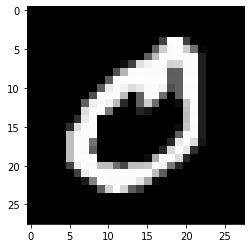

In [63]:
plt.imshow(train_X[1], cmap='gray')

In [64]:
gen_model = GeneratorModel()

(0.5091183694606127,
 0.4096864017003847,
 1.0222388257453466e-08,
 0.9999999983920935)

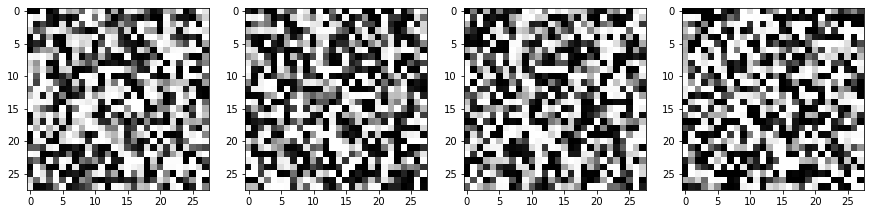

In [65]:
def gen_fake_pics(model, batch_size, batch_num=1):
    pics = np.empty((batch_size*batch_num, 28, 28, 1))
    for i in range(batch_num):
        res = model.forward(cp.random.randn(batch_size, 100))
        res = res.get()
        pics[i:i+batch_size] = res
    return pics

# gen_model = GeneratorModel()
# dis_model = Discriminator()

fake_pics = gen_fake_pics(gen_model, 5)
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(fake_pics[0], cmap='gray')
plt.subplot(1, 4, 2)
plt.imshow(fake_pics[1], cmap='gray')
plt.subplot(1, 4, 3)
plt.imshow(fake_pics[2], cmap='gray')
plt.subplot(1, 4, 4)
plt.imshow(fake_pics[3], cmap='gray')

fake_pics.mean(),  fake_pics.std(), fake_pics.min(), fake_pics.max(), 

Epoch 0-0:  Gen Loss: 0.69315   Dis Loss: 2.41826    Dis GEN: 0.00000 +- 0.0000000    Dis ALL: 0.79973 +- 0.24205


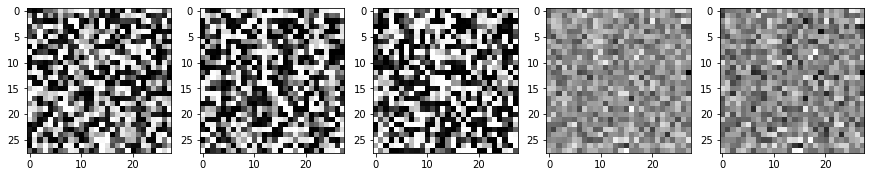

Epoch 1-0:  Gen Loss: 0.53268   Dis Loss: 0.85895    Dis GEN: 0.35176 +- 0.0137719    Dis ALL: 0.33844 +- 0.06778


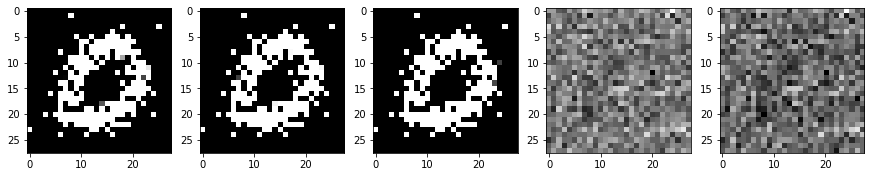

Epoch 2-0:  Gen Loss: 0.51555   Dis Loss: 0.67460    Dis GEN: 0.39370 +- 0.0026682    Dis ALL: 0.42148 +- 0.09289


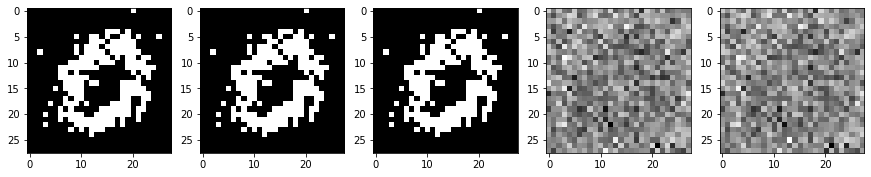

Epoch 3-0:  Gen Loss: 0.52550   Dis Loss: 0.63717    Dis GEN: 0.36918 +- 0.0030449    Dis ALL: 0.36305 +- 0.12329


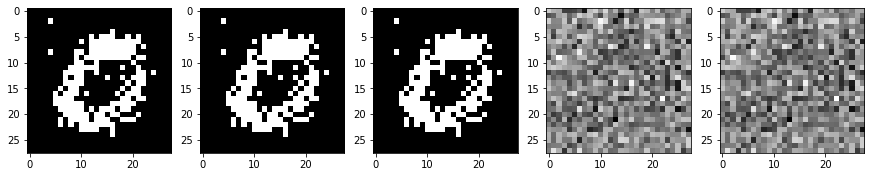

Epoch 4-0:  Gen Loss: 0.58635   Dis Loss: 0.56107    Dis GEN: 0.22638 +- 0.0000000    Dis ALL: 0.46651 +- 0.25608


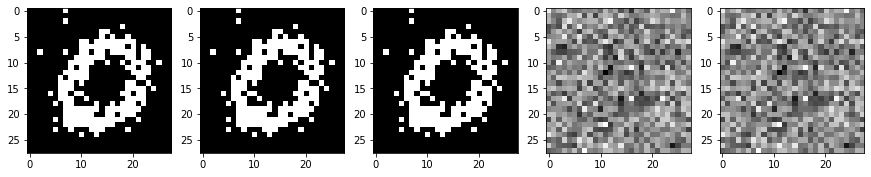

Epoch 5-0:  Gen Loss: 0.53406   Dis Loss: 0.71289    Dis GEN: 0.34835 +- 0.0000000    Dis ALL: 0.40808 +- 0.28838


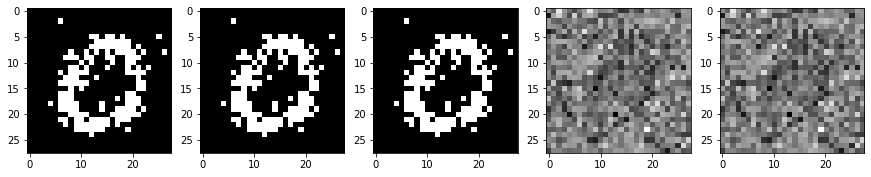

Epoch 6-0:  Gen Loss: 0.48018   Dis Loss: 0.23133    Dis GEN: 0.48391 +- 0.0000000    Dis ALL: 0.50583 +- 0.34659


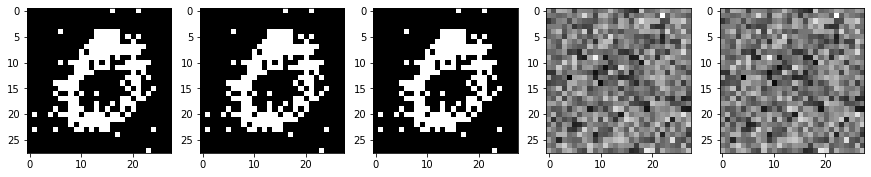

Epoch 7-0:  Gen Loss: 0.56742   Dis Loss: 0.24666    Dis GEN: 0.26958 +- 0.0000000    Dis ALL: 0.59167 +- 0.31732


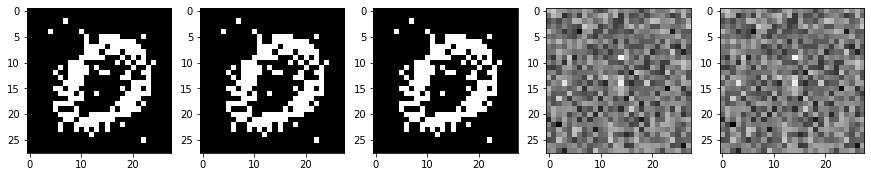

Epoch 8-0:  Gen Loss: 0.59247   Dis Loss: 0.22523    Dis GEN: 0.21265 +- 0.0000000    Dis ALL: 0.47742 +- 0.39074


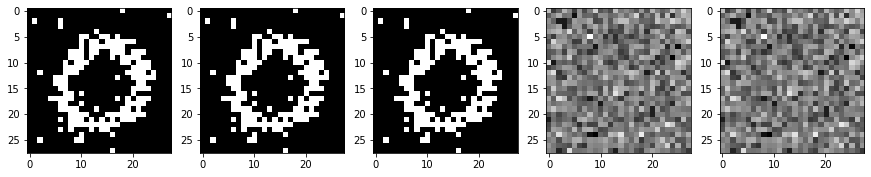

Epoch 9-0:  Gen Loss: 0.56527   Dis Loss: 0.15883    Dis GEN: 0.27454 +- 0.0000000    Dis ALL: 0.48302 +- 0.40253


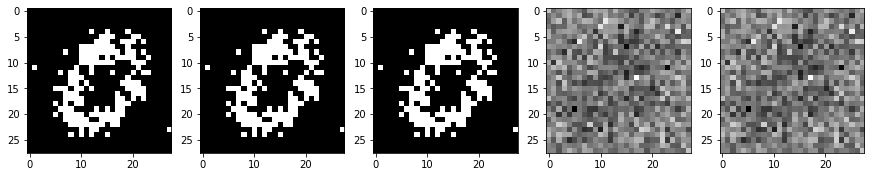

Epoch 10-0:  Gen Loss: 0.65427   Dis Loss: 0.12425    Dis GEN: 0.07932 +- 0.0000000    Dis ALL: 0.54410 +- 0.40837


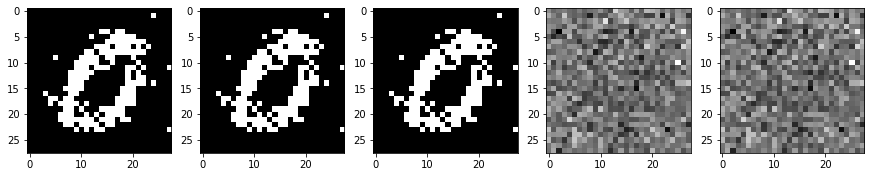

Epoch 11-0:  Gen Loss: 0.65335   Dis Loss: 0.08781    Dis GEN: 0.08124 +- 0.0000000    Dis ALL: 0.52036 +- 0.44159


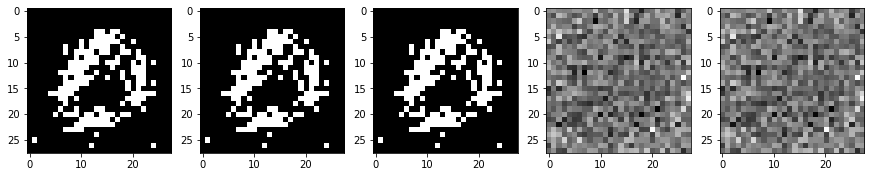

Epoch 12-0:  Gen Loss: 0.63737   Dis Loss: 0.16730    Dis GEN: 0.11485 +- 0.0000000    Dis ALL: 0.51571 +- 0.41366


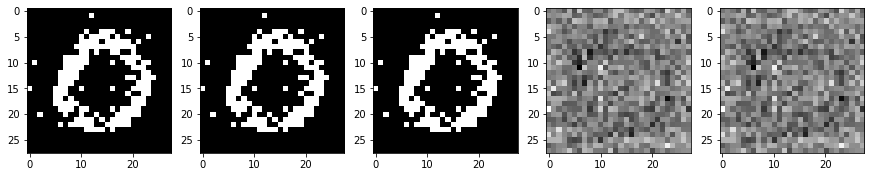

Epoch 13-0:  Gen Loss: 0.65837   Dis Loss: 0.16391    Dis GEN: 0.07081 +- 0.0000000    Dis ALL: 0.59057 +- 0.37422


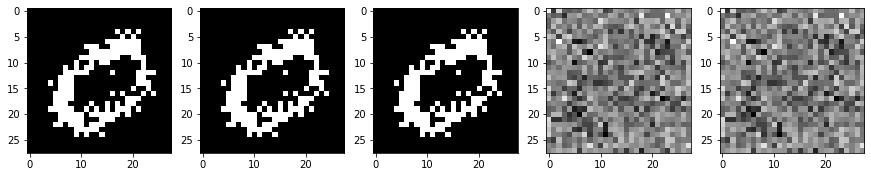

Epoch 14-0:  Gen Loss: 0.65944   Dis Loss: 0.05796    Dis GEN: 0.06860 +- 0.0000000    Dis ALL: 0.52455 +- 0.45517


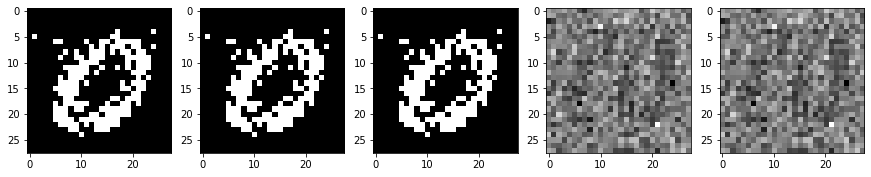

In [67]:
#Fake is 0, real is 1
mempool = cp.get_default_memory_pool()
from tqdm.notebook import tqdm
from copy import deepcopy
from layers import softmax_with_cross_entropy, l2_regularization

def setup_optimizers(model):
    params = model.params()
    model.optimizers = {}
    for param_name, param in params.items():
        model.optimizers[param_name] = deepcopy(model.optim)


def train_discriminator(dis_model, x, y):
    batch_X_gpu = cp.asarray(x)
    batch_y_gpu = cp.asarray(y, dtype=int)
    for param in dis_model.params().values():
        param.grad.fill(0)

    dis_out = dis_model.forward(batch_X_gpu).reshape(-1)

    dis_loss, dis_grad = softmax_with_cross_entropy(dis_out, batch_y_gpu)

    probs_dis = 1/(1+cp.exp(-dis_out))
    dis_model.backward( dis_grad.reshape(-1, 1))
    for param_name, param in dis_model.params().items():
        optimizer = dis_model.optimizers[param_name]
        optimizer.update(param.value, param.grad, learning_rate_dis)
    
    return dis_loss, probs_dis



def train_gan(gen_model, dis_model, n_epochs=100, batch_size=256):
    num_train=len(train_X)
    set_size = int(batch_size/2)
    
    
    for epoch in range(n_epochs):
        # TRAIN DISCRIMINATOR
        
        dis_losses=[]
        
        shuffled_indices = np.arange(num_train)
        np.random.shuffle(shuffled_indices)
        sections = np.arange(set_size, num_train, set_size)
        batches_indices = np.array_split(shuffled_indices, sections)
        
        for batches_id, batch_indices in tqdm(enumerate(batches_indices)):
            
            for _ in range(1):
                dis_model.training_mode[0] = True
                fake_pics = gen_fake_pics(gen_model, set_size)
                real_pics = train_X[batch_indices]    
                y = np.concatenate((np.zeros(set_size), np.ones(set_size)), axis=0)
                x = np.concatenate((fake_pics, real_pics), axis=0)

                dis_loss, probs_dis = train_discriminator(dis_model, x, y)
                dis_losses.append(dis_loss)
                mempool.free_all_blocks()
                cv2.imwrite(f"{number}/{epoch*len(batches_indices)+batches_id}.png", fake_pics[0]*255)

            
            for counter in range(5):
                # TRAIN GENERATOR
                dis_model.training_mode[0] = False
                
                for param in gen_model.params().values():
                    param.grad.fill(0)
                fake_pics = gen_fake_pics(gen_model, 128)
                batch_X_gpu = cp.asarray(fake_pics)
                dis_out = dis_model.forward(batch_X_gpu).reshape(-1)
                probs = 1/(1+cp.exp(-dis_out))
                
                gen_loss, dis_grad = softmax_with_cross_entropy(probs, cp.ones(len(probs), dtype=int))
                
                for param in dis_model.params().values():
                    param.grad.fill(0)
                
                gen_grad = dis_model.backward(dis_grad.reshape(-1, 1))                
                l2_loss = gen_model.backward(gen_grad)
                gen_loss += l2_loss

                for param_name, param in gen_model.params().items():
                    optimizer = gen_model.optimizers[param_name]
                    optimizer.update(param.value, param.grad, learning_rate_gen)
                
            
            if batches_id%100 == 0:
                print(f'Epoch {epoch}-{batches_id}:  Gen Loss: {gen_loss:.5f}   Dis Loss: {np.mean(dis_loss):.5f}    \
Dis GEN: {probs.mean():.5f} +- {probs.std() :.7f}    Dis ALL: {probs_dis.mean():.5f} +- {probs_dis.std():.5f}')
            # if batches_id%50 == 0:
                plt.figure(figsize=(15, 5))
                plt.subplot(1, 5, 1)
                plt.imshow(fake_pics[0], cmap='gray')
                plt.subplot(1, 5, 2)
                plt.imshow(fake_pics[1], cmap='gray')
                plt.subplot(1, 5, 3)
                plt.imshow(fake_pics[2], cmap='gray')
                plt.subplot(1, 5, 4)
                plt.imshow(gen_grad[0].get(), cmap='gray')
                plt.subplot(1, 5, 5)
                plt.imshow(gen_grad.mean(axis=0).get(), cmap='gray')
                plt.show()
            

        
gen_model = GeneratorModel()
dis_model = Discriminator()
dis_model.optim = SGD()
gen_model.optim = Adam()
setup_optimizers(gen_model)
setup_optimizers(dis_model)

learning_rate_dis = 0.0002#1e-4
learning_rate_gen = 0.0002 #1e-4

gen_loss= -1
dis_loss= -1
probs_dis = np.array([-1])
probs = np.array([-1])    

train_gan(gen_model, dis_model, batch_size=256, n_epochs=15)